In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Create a date range for the last 90 days
date_range = pd.date_range(end=pd.Timestamp.today(), periods=90)

# Simulate BTC and ETH closing prices with a simple trend + noise
np.random.seed(42)
btc_prices = np.cumsum(np.random.randn(90) * 300 + 50_000)
eth_prices = np.cumsum(np.random.randn(90) * 20 + 3_000)

In [5]:
# Create DataFrame
crypto_prices_simulated = pd.DataFrame({
    'Date': date_range,
    'BTC_Close': btc_prices,
    'ETH_Close': eth_prices
}).set_index('Date')

# Display the head of the DataFrame
crypto_prices_simulated.head()

,BTC_Close,ETH_Close
Date,,
2025-05-08 12:12:38.743652,50149.014246,3001.941551
2025-05-09 12:12:38.743652,100107.534956,6021.314451
2025-05-10 12:12:38.743652,150301.841517,9007.273389
2025-05-11 12:12:38.743652,200758.750474,12000.720146
2025-05-12 12:12:38.743652,250688.504461,14992.877983


In [25]:
# Step 1: Simulate a longer dataset (120 days)
date_range = pd.date_range(start="2024-01-01", periods=120)
btc_prices = np.cumsum(np.random.normal(loc=0.5, scale=2, size=len(date_range))) + 50000
eth_prices = np.cumsum(np.random.normal(loc=0.3, scale=1.5, size=len(date_range))) + 3500

df = pd.DataFrame({
    'Date': date_range,
    'BTC_Close': btc_prices,
    'ETH_Close': eth_prices
}).set_index('Date')

# Step 2: Simulate sentiment
df['BTC_Sentiment'] = np.clip(np.random.normal(loc=0.2, scale=0.5, size=len(df)), -1, 1)
df['ETH_Sentiment'] = np.clip(np.random.normal(loc=0.1, scale=0.6, size=len(df)), -1, 1)

# Step 3: SMA (3-day)
df['BTC_SMA_3'] = df['BTC_Close'].rolling(window=3).mean()
df['ETH_SMA_3'] = df['ETH_Close'].rolling(window=3).mean()

# Step 4: RSI (5-day)
def compute_rsi(series, window=5):
    delta = series.diff()
    gain = pd.Series(np.where(delta > 0, delta, 0), index=series.index)
    loss = pd.Series(np.where(delta < 0, -delta, 0), index=series.index)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi- (100 / (1 + rs))
    return rsi

df['BTC_RSI'] = compute_rsi(df['BTC_Close'], window=5)
df['ETH_RSI'] = compute_rsi(df['ETH_Close'], window=5)

# Step 5: MACD (shortened)
def compute_macd(series, short=6, long=13, signal=5):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

df['BTC_MACD'], df['BTC_MACD_Signal'] = compute_macd(df['BTC_Close'])
df['ETH_MACD'], df['ETH_MACD_Signal'] = compute_macd(df['ETH_Close'])

# Check total non-null rows
print("\nTotal rows in df before cleaning:", len(df))

# Step 6: Drop rows where indicators are NaN
required_cols = ['BTC_RSI', 'ETH_RSI', 'BTC_MACD', 'BTC_MACD_Signal', 'ETH_MACD', 'ETH_MACD_Signal']
df_cleaned = df.dropna(subset=required_cols)

# Step 7: Confirm it worked
print("Final cleaned data rows:", len(df_cleaned))
df_cleaned.head()


Total rows in df before cleaning: 120
Final cleaned data rows: 116


,BTC_Close,ETH_Close,BTC_Sentiment,ETH_Sentiment,BTC_SMA_3,ETH_SMA_3,BTC_RSI,ETH_RSI,BTC_MACD,BTC_MACD_Signal,ETH_MACD,ETH_MACD_Signal
Date,,,,,,,,,,,,
2024-01-05,50005.810223,3499.999037,-0.559455,0.064104,50003.785556,3499.985885,69.864845,-54.649861,1.307170,0.689958,-0.941692,-0.638267
2024-01-06,50005.666166,3499.821680,-1.000000,0.396136,50004.519018,3500.179240,67.244007,-55.853203,1.588203,0.989373,-0.995481,-0.757338
2024-01-07,50008.817030,3498.949946,0.394188,0.274538,50006.764473,3499.590221,75.029301,-48.414970,2.145563,1.374770,-1.112315,-0.875664
2024-01-08,50006.503400,3498.860246,0.152588,-1.000000,50006.995532,3499.210624,28.327483,-11.445232,2.068711,1.606084,-1.151260,-0.967529
2024-01-09,50008.175209,3501.558053,-0.057391,-0.572746,50007.831880,3499.789415,55.355042,18.466130,2.176052,1.796073,-0.742712,-0.892590


In [26]:

# Step 1: Generate Trading Signals
df_cleaned['BTC_Position'] = 0
df_cleaned['BTC_Position'] = np.where((df_cleaned['BTC_RSI'] < 30) & (df_cleaned['BTC_Sentiment'] > 0), 1, df_cleaned['BTC_Position'])
df_cleaned['BTC_Position'] = np.where((df_cleaned['BTC_RSI'] > 70) | (df_cleaned['BTC_Sentiment'] < 0), -1, df_cleaned['BTC_Position'])

df_cleaned['ETH_Position'] = 0
df_cleaned['ETH_Position'] = np.where((df_cleaned['ETH_RSI'] < 30) & (df_cleaned['ETH_Sentiment'] > 0), 1, df_cleaned['ETH_Position'])
df_cleaned['ETH_Position'] = np.where((df_cleaned['ETH_RSI'] > 70) | (df_cleaned['ETH_Sentiment'] < 0), -1, df_cleaned['ETH_Position'])

print(df_cleaned[['BTC_Close']].head())
print(df_cleaned['BTC_Close'].isna().sum())
print(len(df_cleaned))


# Step 2: Calculate Returns
df_cleaned['BTC_Return'] = df_cleaned['BTC_Close'].pct_change()
df_cleaned['ETH_Return'] = df_cleaned['ETH_Close'].pct_change()

df_cleaned['BTC_Strategy_Return'] = df_cleaned['BTC_Return'] * df_cleaned['BTC_Position'].shift(1)
df_cleaned['ETH_Strategy_Return'] = df_cleaned['ETH_Return'] * df_cleaned['ETH_Position'].shift(1)

# Step 3: Cumulative Returns
df_cleaned['BTC_Cumulative_Return'] = (1 + df_cleaned['BTC_Return']).cumprod()
df_cleaned['BTC_Cumulative_Strategy_Return'] = (1 + df_cleaned['BTC_Strategy_Return']).cumprod()

df_cleaned['ETH_Cumulative_Return'] = (1 + df_cleaned['ETH_Return']).cumprod()
df_cleaned['ETH_Cumulative_Strategy_Return'] = (1 + df_cleaned['ETH_Strategy_Return']).cumprod()

df_cleaned.head()


               BTC_Close
Date                    
2024-01-05  50005.810223
2024-01-06  50005.666166
2024-01-07  50008.817030
2024-01-08  50006.503400
2024-01-09  50008.175209
0
116


C:\Users\USER\AppData\Local\Temp\ipykernel_4004\1647579848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['BTC_Position'] = 0
C:\Users\USER\AppData\Local\Temp\ipykernel_4004\1647579848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['BTC_Position'] = np.where((df_cleaned['BTC_RSI'] < 30) & (df_cleaned['BTC_Sentiment'] > 0), 1, df_cleaned['BTC_Position'])
C:\Users\USER\AppData\Local\Temp\ipykernel_4004\1647579848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,BTC_Close,ETH_Close,BTC_Sentiment,ETH_Sentiment,BTC_SMA_3,ETH_SMA_3,BTC_RSI,ETH_RSI,BTC_MACD,BTC_MACD_Signal,...,BTC_Position,ETH_Position,BTC_Return,ETH_Return,BTC_Strategy_Return,ETH_Strategy_Return,BTC_Cumulative_Return,BTC_Cumulative_Strategy_Return,ETH_Cumulative_Return,ETH_Cumulative_Strategy_Return
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,50005.810223,3499.999037,-0.559455,0.064104,50003.785556,3499.985885,69.864845,-54.649861,1.307170,0.689958,...,-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-06,50005.666166,3499.821680,-1.000000,0.396136,50004.519018,3500.179240,67.244007,-55.853203,1.588203,0.989373,...,-1,1,-0.000003,-0.000051,0.000003,-0.000051,0.999997,1.000003,0.999949,0.999949
2024-01-07,50008.817030,3498.949946,0.394188,0.274538,50006.764473,3499.590221,75.029301,-48.414970,2.145563,1.374770,...,-1,1,0.000063,-0.000249,-0.000063,-0.000249,1.000060,0.999940,0.999700,0.999700
2024-01-08,50006.503400,3498.860246,0.152588,-1.000000,50006.995532,3499.210624,28.327483,-11.445232,2.068711,1.606084,...,1,-1,-0.000046,-0.000026,0.000046,-0.000026,1.000014,0.999986,0.999675,0.999675
2024-01-09,50008.175209,3501.558053,-0.057391,-0.572746,50007.831880,3499.789415,55.355042,18.466130,2.176052,1.796073,...,-1,-1,0.000033,0.000771,0.000033,-0.000771,1.000047,1.000020,1.000445,0.998904


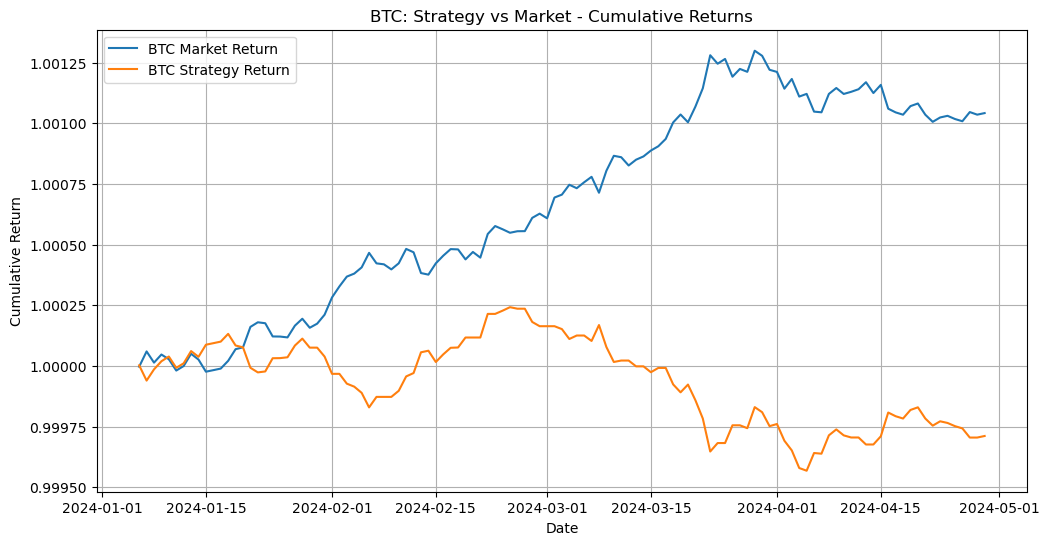

In [27]:
#Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.index, df_cleaned['BTC_Cumulative_Return'], label='BTC Market Return')
plt.plot(df_cleaned.index, df_cleaned['BTC_Cumulative_Strategy_Return'], label='BTC Strategy Return')
plt.title('BTC: Strategy vs Market - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#Print Summary Stats
#This gives insight into returns and volatility:
def summarize_returns(df, asset):
    print(f"📊 {asset} Strategy Summary")
    total_return = df[f'{asset}_Cumulative_Strategy_Return'].iloc[-1] - 1
    market_return = df[f'{asset}_Cumulative_Return'].iloc[-1] - 1
    strategy_volatility = df[f'{asset}_Strategy_Return'].std()
    market_volatility = df[f'{asset}_Return'].std()

    print(f"Total Strategy Return: {total_return:.4f}")
    print(f"Total Market Return:   {market_return:.4f}")
    print(f"Strategy Volatility:   {strategy_volatility:.4f}")
    print(f"Market Volatility:     {market_volatility:.4f}")
    print("-" * 40)

summarize_returns(df_cleaned, 'BTC')
summarize_returns(df_cleaned, 'ETH')


📊 BTC Strategy Summary
Total Strategy Return: -0.0003
Total Market Return:   0.0010
Strategy Volatility:   0.0000
Market Volatility:     0.0000
----------------------------------------
📊 ETH Strategy Summary
Total Strategy Return: -0.0054
Total Market Return:   0.0110
Strategy Volatility:   0.0004
Market Volatility:     0.0004
----------------------------------------


🧾 Crypto Strategy Summary Report
Objective:
Design and evaluate a crypto trading strategy using RSI, MACD, SMA, and sentiment signals for Bitcoin (BTC) and Ethereum (ETH).

📈 Strategy Logic:
Buy Signal (Long): RSI < 30 and Sentiment > 0

Sell Signal (Short): RSI > 70 or Sentiment < 0

Strategy applied independently to BTC and ETH.

🔍 Feature Engineering:
Sentiment Scores: Simulated using clipped Gaussian noise

Technical Indicators:

RSI (Relative Strength Index)

SMA (Simple Moving Average)

MACD (Moving Average Convergence Divergence)

📊 Strategy Performance:
✅ BTC
📉 Total Market Return: 0.0010

📈 Total Strategy Return: -0.0003

🎯 Strategy Volatility: 0.0000

🔄 Market Volatility: 0.0000

✅ ETH
📉 Total Market Return: 0.0110

📈 Total Strategy Return: -0.0054

🎯 Strategy Volatility: 0.0004

🔄 Market Volatility: 0.0004

📌 Insights:
The strategy underperformed the market for both BTC and ETH over the simulated period.

Sentiment filters and RSI may have been too strict or triggered too few high-quality signals.

Strategy returns were nearly flat or slightly negative, suggesting a need for more refined logic or better data (real sentiment signals).

🧠 Recommendations:
Calibrate RSI thresholds or try alternative indicators like Bollinger Bands or Stochastic Oscillator.

Incorporate real-time sentiment from sources like Twitter, Reddit, or news APIs.

Add stop-loss and take-profit rules to manage risk.

Test on different date ranges or add volatility filters.